In [ ]:
pip install mesa

In [164]:
import matplotlib.pyplot as plt
import numpy as np
from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import pandas as pd
import seaborn as sns 
import matplotlib.colors as mcolors

In [183]:
# Patch class representing a patch of flowers
class Patch(Agent):
    def __init__(self, unique_id, model, nectar_amount, size):
        super().__init__(unique_id, model)
        self.nectar_amount = nectar_amount
        self.initial_nectar_amount = nectar_amount
        self.size = size
        self.visits = 0
        self.profitability = 1.0
        self.bees_traveling = 0

    def update_profitability(self):
        self.profitability = (self.nectar_amount / self.initial_nectar_amount) * (0.999 ** self.visits)
        self.visits += 1


# PatchCell class to represent individual cells of a patch
class PatchCell(Agent):
    def __init__(self, unique_id, model, parent_patch):
        super().__init__(unique_id, model)
        self.parent_patch = parent_patch



In [184]:
# Bee class representing a bee with different roles
class Bee(Agent):
    def __init__(self, unique_id, model, speed, role="novice"):
        super().__init__(unique_id, model)
        self.speed = speed
        self.has_food = False 
        self.role = role
        self.patch = None
        self.nectar_collected = 0
        self.waggle_time = 0
        self.communicated = False
        self.novice_target_distance = None 
        self.target_pos = None
        self.failed_trips = np.random.randint(1, 6) if role == "recruit" else 0
        self.failed_trip_distance = None
        self.recruit_state = "outbound"
        self.released = False
        self.waiting_time = 0  # New attribute to track waiting time at the hive

    def step(self):
        if self.role == "novice":
            self.novice_behavior()
        elif self.role == "scout":
            self.scout_behavior()
        elif self.role == "recruit":
            self.recruit_behavior()
        elif self.role == "employed":
            self.employed_behavior()

    def novice_behavior(self):
        if not self.released:
            return
        if self.communicated:
            if sum(1 for agent in self.model.schedule.agents if isinstance(agent, Bee) and agent.role == "novice" and agent.pos == self.model.hive_pos) > 20:
                self.role = "recruit"
                self.target_pos = self.patch.pos if self.patch else None
        else:
            if self.novice_target_distance is None:
                self.novice_target_distance = np.random.randint(150, 156)
            self.travel_straight_line_as_novice()
            self.find_patch()

    def recruit_behavior(self):
        if self.recruit_state == "outbound":
            self.perform_outbound_behavior()
        elif self.recruit_state == "returning":
            self.perform_returning_behavior()
        elif self.recruit_state == "heading_to_patch":
            self.travel_straight_line_as_recruit()

    def scout_behavior(self):
        self.leave_hive()
        if not self.released:
            return
        if self.has_food:
            self.return_to_hive()
            if self.pos == self.model.hive_pos:
                self.model.total_nectar_collected += self.nectar_collected
                self.nectar_collected = 0
                self.has_food = False
                self.perform_waggle()
        else:
            if self.novice_target_distance is None:
                self.novice_target_distance = np.random.randint(150, 156)
            self.travel_straight_line_as_novice()
            self.find_patch()
            if self.patch and self.pos == self.patch.pos:
                self.collect_nectar()

    def employed_behavior(self):
        if self.has_food:
            self.return_to_hive()
            if self.pos == self.model.hive_pos:
                self.model.total_nectar_collected += self.nectar_collected
                self.nectar_collected = 0
                self.has_food = False
                self.waiting_time = 10
        else:
            if self.pos == self.model.hive_pos:
                self.waiting_time -= 1
                self.listen_for_waggle() 
                if self.waiting_time <= 0:
                    self.leave_hive()
            else:
                if self.patch and not self.has_food:
                    # Calculate distance-to-nectar ratio
                    distance_to_patch = np.linalg.norm(np.array(self.patch.pos) - np.array(self.model.hive_pos))
                    nectar_value = self.patch.nectar_amount / distance_to_patch

                    # If nectar value is low, decide to search for a new patch
                    if nectar_value < 0.1:  # Consider adjusting this threshold
                        self.patch.bees_traveling -= 1  # Decrease bees_traveling count
                        self.model.patch_changes += 1  # Increment patch change counter
                        self.patch = None 
                        self.role = "novice"
                    else:
                        self.move_straight_line(self.patch.pos)
                        if self.pos == self.patch.pos:
                            self.collect_nectar()

    def listen_for_waggle(self):
        for agent in self.model.grid.get_cell_list_contents([self.pos]):
            if isinstance(agent, Bee) and agent.role == "employed" and agent.patch and agent != self:
                # Calculate weighted nectar value for the new patch
                new_patch_distance = np.linalg.norm(np.array(agent.patch.pos) - np.array(self.model.hive_pos))
                current_patch_distance = np.linalg.norm(np.array(self.patch.pos) - np.array(self.model.hive_pos))
                
                # New patch value considering both nectar and distance
                new_patch_value = agent.patch.nectar_amount / (new_patch_distance ** 2)
                current_patch_value = self.patch.nectar_amount / (current_patch_distance ** 2)
                
                # Switch to the new patch if its value is greater
                if new_patch_value > current_patch_value:
                    self.patch = agent.patch
                    self.target_pos = agent.patch.pos
                    self.model.patch_changes += 1  # Track patch changes
                    self.waggle_time = 0
                    break


    def perform_waggle(self):
        if self.model.use_waggle_dance and self.patch:
            profitability_multiplier = self.patch.profitability * 2 
            self.waggle_time = int(np.linalg.norm(np.array(self.patch.pos) - np.array(self.model.hive_pos)) * 1000 / self.speed)
            novices_in_hive = [agent for agent in self.model.schedule.agents if isinstance(agent, Bee) and agent.role == "novice" and agent.pos == self.model.hive_pos]
            base_recruitment = np.random.randint(1, 6)
            num_to_communicate = min(len(novices_in_hive), int(base_recruitment * profitability_multiplier))
            for agent in np.random.choice(novices_in_hive, num_to_communicate, replace=False):
                agent.role = "recruit"
                agent.patch = self.patch
                agent.communicated = True
                agent.target_pos = self.target_pos

    def perform_outbound_behavior(self):
        if self.failed_trip_distance is None:
            self.failed_trip_distance = self.model.distance + np.random.randint(1, 6)
            angle = np.random.uniform(0, 2 * np.pi)
            self.target_pos = (
                int(self.model.hive_pos[0] + self.failed_trip_distance * np.cos(angle)),
                int(self.model.hive_pos[1] + self.failed_trip_distance * np.sin(angle))
            )

        # Check if the recruit encounters a patch cell
        for agent in self.model.grid.get_cell_list_contents([self.pos]):
            if isinstance(agent, PatchCell) and agent.parent_patch.nectar_amount > 0:
                self.patch = agent.parent_patch
                self.patch.bees_traveling += 1  # Increase bees_traveling count
                self.collect_nectar()
                self.role = "employed"
                self.failed_trips = 0  # Stop the failed trips
                return

        self.travel_straight_line_as_recruit()

    def perform_returning_behavior(self):
        self.return_to_hive()
        if self.pos == self.model.hive_pos:
            self.returning_to_hive = False
            self.failed_trips -= 1
            self.failed_trip_distance = None
            self.target_pos = None
            if self.failed_trips > 0:
                self.recruit_state = "outbound"
            else:
                self.recruit_state = "heading_to_patch"
                if self.patch: 
                    self.target_pos = self.patch.pos

    def travel_straight_line_as_recruit(self):
        if self.target_pos is None:
            return
        if np.linalg.norm(np.array(self.pos) - np.array(self.target_pos)) > self.speed:
            self.move_straight_line(self.target_pos)
        else:
            if self.recruit_state == "outbound":
                self.recruit_state = "returning"
            elif self.recruit_state == "heading_to_patch":
                for agent in self.model.grid.get_cell_list_contents([self.target_pos]):
                    if isinstance(agent, PatchCell) and agent.parent_patch.nectar_amount > 0:
                        self.patch = agent.parent_patch
                        self.patch.bees_traveling += 1  # Increase bees_traveling count
                        self.collect_nectar()
                        self.role = "employed"
                        break

    def move_straight_line(self, target):
        if target:
            direction = np.arctan2(target[1] - self.pos[1], target[0] - self.pos[0])
            new_position = (
                int(round(self.pos[0] + self.speed * np.cos(direction))),
                int(round(self.pos[1] + self.speed * np.sin(direction)))
            )
            if 0 <= new_position[0] < self.model.grid.width and 0 <= new_position[1] < self.model.grid.height:
                self.model.grid.move_agent(self, new_position)

    def random_move(self):
        angle = np.deg2rad(self.random.choice(range(0, 360, 5)))
        target = (self.pos[0] + self.speed * np.cos(angle), self.pos[1] + self.speed * np.sin(angle))
        target = (int(round(target[0])), int(round(target[1])))
        if 0 <= target[0] < self.model.grid.width and 0 <= target[1] < self.model.grid.height:
            self.model.grid.move_agent(self, target)

    def return_to_hive(self):
        self.move_straight_line(self.model.hive_pos)

    def travel_straight_line_as_novice(self):
        if self.target_pos is None:
            angle = np.random.uniform(0, 2 * np.pi)
            self.target_pos = (
                int(self.model.hive_pos[0] + self.novice_target_distance * np.cos(angle)),
                int(self.model.hive_pos[1] + self.novice_target_distance * np.sin(angle))
            )
        if np.linalg.norm(np.array(self.pos) - np.array(self.target_pos)) > self.speed:
            self.move_straight_line(self.target_pos)
        else:
            self.return_to_hive()
            self.novice_target_distance = None
            self.target_pos = None

    def find_patch(self):
        for agent in self.model.grid.get_cell_list_contents([self.pos]):
            if isinstance(agent, PatchCell) and agent.parent_patch.nectar_amount > 0:
                self.patch = agent.parent_patch
                self.patch.bees_traveling += 1  # Increase bees_traveling count
                self.target_pos = agent.pos
                self.role = "employed"
                break

    def collect_nectar(self):
        nectar_amount = np.random.randint(15, 41)
        if self.patch:
            self.nectar_collected = min(self.patch.nectar_amount, nectar_amount) - 1
            self.patch.nectar_amount -= self.nectar_collected + 1
            self.has_food = True

            if self.patch.nectar_amount <= 0:
                self.patch.nectar_amount = 0
                self.patch.bees_traveling -= 1  # Decrease bees_traveling count
                self.role = "novice"
                self.patch = None

    def leave_hive(self):
        if self.patch:
            self.move_straight_line(self.patch.pos)
        elif self.role == "scout":
            self.released = True  # Ensure scouts are released immediately

In [185]:
# Model to run the experiment with varying nectar quantities and distances
class HoneybeeModel(Model):
    def __init__(self, num_agents, width, height, nectar_quantities, use_waggle_dance, speed):
        super().__init__()
        self.num_agents = num_agents
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.hive_pos = (width // 2, height // 2)
        self.use_waggle_dance = use_waggle_dance
        self.speed = speed
        self.total_nectar_collected = 0
        self.step_count = 0
        self.patch_changes = 0  # To track patch changes

        # Create patches with different sizes, distances, and nectar amounts
        self.patches = []
        for patch_size, (distances, nectars) in nectar_quantities.items():
            for distance, nectar_amount in zip(distances, nectars):
                patch = Patch(self.num_agents + len(self.patches), self, nectar_amount, patch_size)
                angle = np.deg2rad(np.random.uniform(0, 360))
                x = int(self.hive_pos[0] + (distance * np.cos(angle)))
                y = int(self.hive_pos[1] + (distance * np.sin(angle)))
                self.place_patch(patch, x, y)
                self.patches.append(patch)

        # Create bees
        num_novices = int(0.9 * self.num_agents)
        num_scouts = self.num_agents - num_novices

        for i in range(num_novices):
            bee = Bee(i, self, speed, role="novice")
            self.schedule.add(bee)
            self.grid.place_agent(bee, self.hive_pos)

        for i in range(num_scouts):
            bee = Bee(num_novices + i, self, speed, role="scout")
            self.schedule.add(bee)
            self.grid.place_agent(bee, self.hive_pos)

        self.datacollector = DataCollector(
            model_reporters={
                "Total Nectar Collected": lambda m: m.total_nectar_collected,
                "Step": lambda m: m.schedule.time,
                "Patch Changes": lambda m: m.patch_changes,
                "Agents Per Patch": lambda m: m.count_agents_per_patch(),
            },
            agent_reporters={"Role": "role"}
        )


    def place_patch(self, patch, x, y):
        size = patch.size
        for dx in range(size):
            for dy in range(size):
                if 0 <= x + dx < self.grid.width and 0 <= y + dy < self.grid.height:
                    patch_cell = PatchCell(self.num_agents + len(self.schedule.agents), self, patch)
                    self.schedule.add(patch_cell)
                    self.grid.place_agent(patch_cell, (x + dx, y + dy))
        self.grid.place_agent(patch, (x, y))

    def step(self):
        self.schedule.step()
        self.datacollector.collect(self)
        self.step_count += 1

        if self.step_count >= 5 and self.step_count % 5 == 0:
            self.release_novice()

    def release_novice(self):
        num_novices_in_hive = sum(1 for agent in self.schedule.agents if isinstance(agent, Bee) and agent.role == "novice" and agent.pos == self.hive_pos)
        if num_novices_in_hive > 20:
            for agent in self.schedule.agents:
                if isinstance(agent, Bee) and agent.role == "novice" and agent.pos == self.hive_pos and not agent.released:
                    agent.released = True
                    agent.leave_hive()
                    break  # Only one novice is released

    def count_agents_per_patch(self):
        patch_counts = {}
        for patch in self.patches:
            patch_counts[patch.unique_id] = sum(1 for agent in self.schedule.agents if isinstance(agent, Bee) and agent.patch == patch)
        return patch_counts

In [188]:
# Parameters for the experiment
runs = 5
N = 200
width = 400
height = 400
speed = 1
duration = 7200

nectar_quantities = {
    2: ([50, 100, 150], [40000, 20000, 10000]),  
}


def run_experiment_with_exploitation(runs, N, width, height, nectar_quantities, speed, duration, step_interval=600):
    all_results = []

    for _ in range(runs):
        # Model with waggle dance
        model_with_waggle = HoneybeeModel(N, width, height, nectar_quantities, True, speed)
        for step in range(duration):
            model_with_waggle.step()

            # Collecting data at specified intervals
            if step % step_interval == 0:
                for patch in model_with_waggle.patches:
                    all_results.append({
                        "Step": step,
                        "Patch Size": f"{patch.size}x{patch.size}",
                        "Distance from Hive": np.linalg.norm(np.array(patch.pos) - np.array(model_with_waggle.hive_pos)),
                        "Bees Visiting": patch.bees_traveling,
                        "Remaining Nectar": patch.nectar_amount
                    })

    return pd.DataFrame(all_results)
    
results_df = run_experiment_with_exploitation(runs, N, width, height, nectar_quantities, speed, duration) #runs experiment 

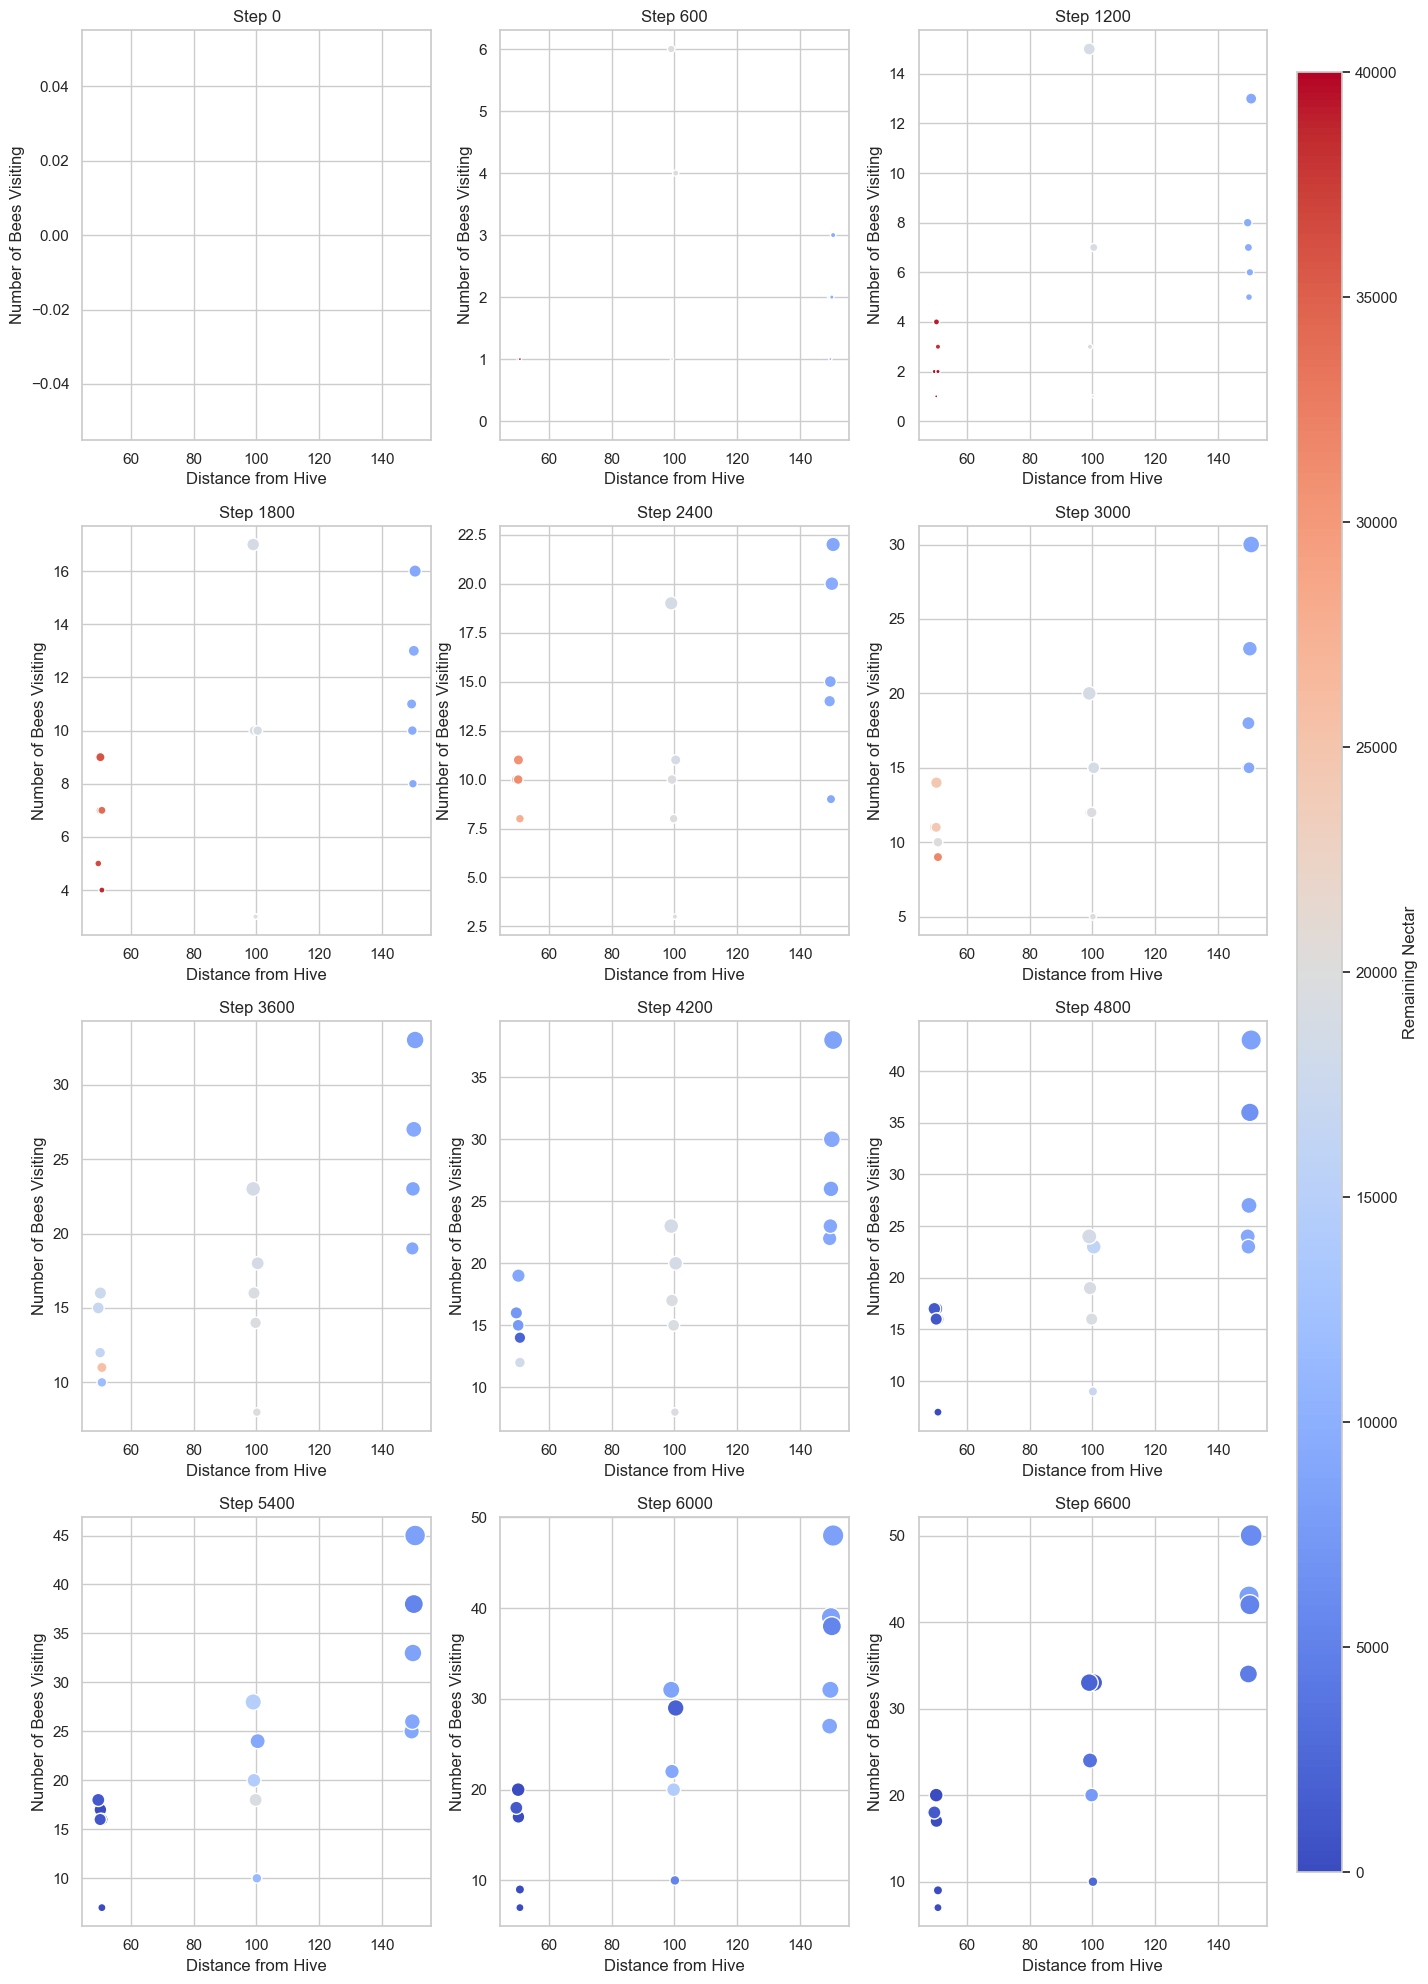

In [189]:
# Define the function to plot subplots at intervals
def plot_distance_vs_resource_exploitation_at_intervals(results_df, interval=600):
    steps = results_df['Step'].unique()
    results_df['Bees Visiting'] = results_df['Bees Visiting'].apply(lambda x: max(x, 0) if pd.notnull(x) else 0)

    # Number of rows and columns for the grid layout
    n_cols = 3
    n_rows = (len(steps) // n_cols) + (len(steps) % n_cols > 0)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    
    # Flatten the axes array for easier iteration
    axs = axs.flatten()

    # Define the normalisation for the color scale
    norm = mcolors.Normalize(vmin=0, vmax=40000)

    # Iterate over steps in intervals and create plots
    for idx, step in enumerate(range(0, max(steps) + 1, interval)):
        subset_df = results_df[results_df["Step"] == step]
        
        if subset_df.empty:
            continue  # Skip if there's no data for this step
        
        ax = axs[idx]

        # Unique patch sizes for the current step
        unique_patch_sizes = subset_df["Patch Size"].unique()
        
        for patch_size in unique_patch_sizes:
            # Filter the data for the current patch size and step
            patch_subset_df = subset_df[subset_df["Patch Size"] == patch_size]
            
            # Scatter plot with size and color representing remaining nectar
            scatter = ax.scatter(
                x=patch_subset_df["Distance from Hive"], 
                y=patch_subset_df["Bees Visiting"], 
                s=patch_subset_df["Bees Visiting"] * 5,  # Adjust size scale as needed
                c=patch_subset_df["Remaining Nectar"], 
                cmap="coolwarm",
                alpha=1,
                edgecolor='w',
                norm=norm  
            )

        ax.set_xlabel("Distance from Hive")
        ax.set_ylabel("Number of Bees Visiting")
        ax.grid(True)
        ax.set_title(f"Step {step}")

    # Hide any unused subplots
    for ax in axs[len(steps):]:
        ax.axis('off')

    # Adjust layout and add colorbar
    fig.tight_layout()
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.87, 0.06, 0.03, 0.9])  # Position of color bar
    fig.colorbar(scatter, cax=cbar_ax, label="Remaining Nectar")
  
    
    plt.show()

plot_distance_vs_resource_exploitation_at_intervals(results_df, interval=600)


In [191]:
# Parameters for the experiment 2
runs = 5
N = 200
width = 400
height = 400
speed = 1
duration = 7200

nectar_quantities = {
    2: ([50, 100, 150], [10000, 20000, 40000]), 
}


def run_experiment_with_exploitation(runs, N, width, height, nectar_quantities, speed, duration, step_interval=600):
    all_results2 = []

    for _ in range(runs):
        # Model with waggle dance
        model_with_waggle = HoneybeeModel(N, width, height, nectar_quantities, True, speed)
        for step in range(duration):
            model_with_waggle.step()

            # Collecting data at specified intervals
            if step % step_interval == 0:
                for patch in model_with_waggle.patches:
                    all_results2.append({
                        "Step": step,
                        "Patch Size": f"{patch.size}x{patch.size}",
                        "Distance from Hive": np.linalg.norm(np.array(patch.pos) - np.array(model_with_waggle.hive_pos)),
                        "Bees Visiting": patch.bees_traveling,
                        "Remaining Nectar": patch.nectar_amount
                    })

    return pd.DataFrame(all_results2)
    
results_df = run_experiment_with_exploitation(runs, N, width, height, nectar_quantities, speed, duration)

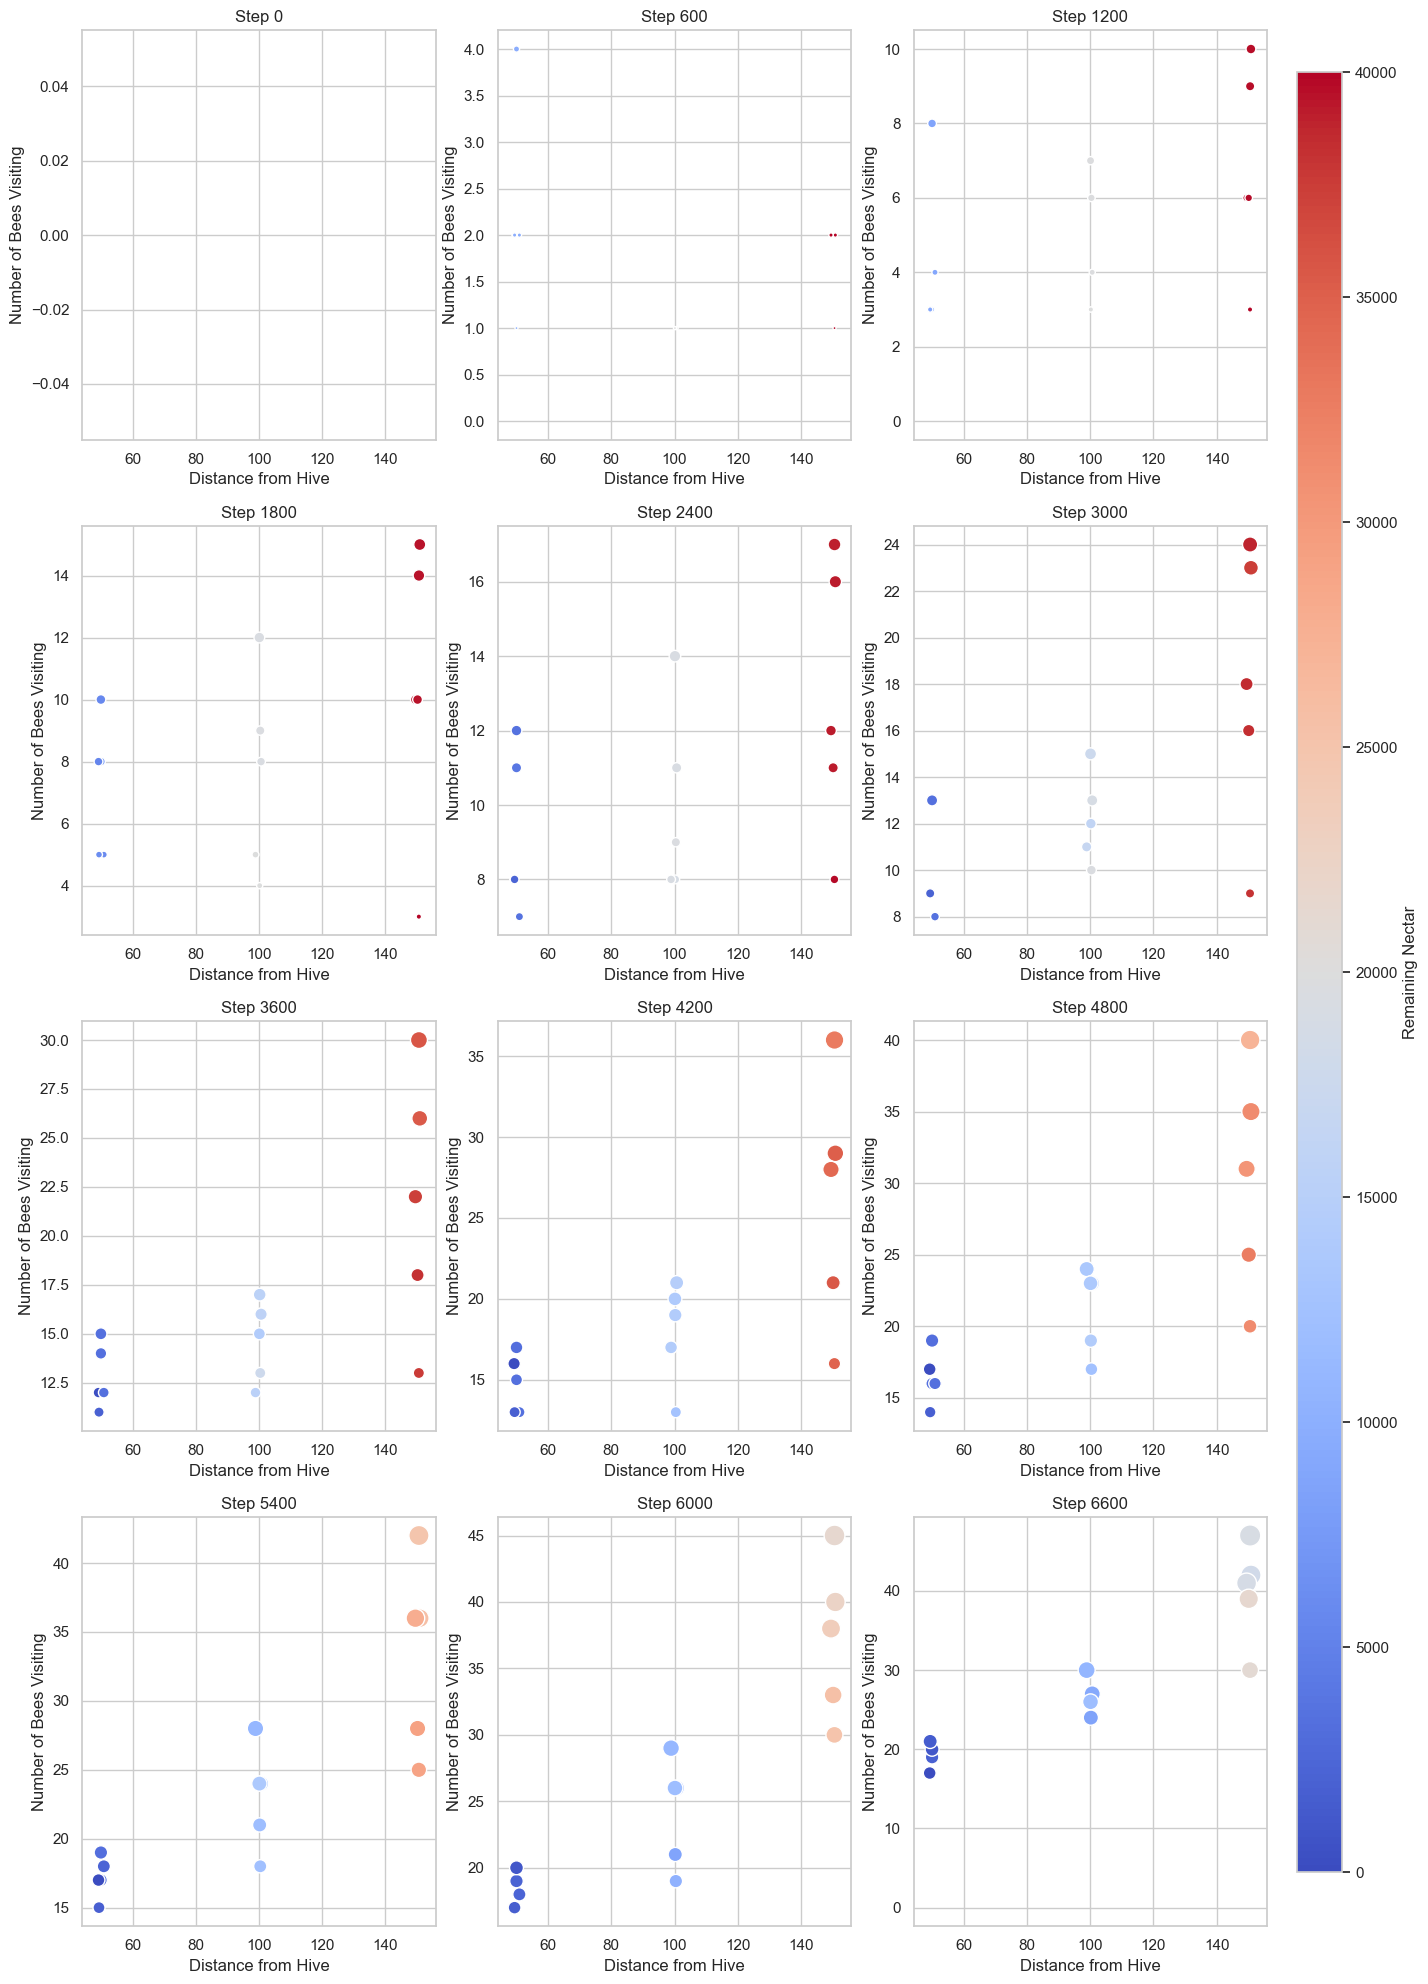

In [192]:
# Define the function to plot subplots at intervals
def plot_distance_vs_resource_exploitation_at_intervals(results_df, interval=600):
    steps = results_df['Step'].unique()
    results_df['Bees Visiting'] = results_df['Bees Visiting'].apply(lambda x: max(x, 0) if pd.notnull(x) else 0)

    # Number of rows and columns for the grid layout
    n_cols = 3
    n_rows = (len(steps) // n_cols) + (len(steps) % n_cols > 0)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    
    # Flatten the axes array for easier iteration
    axs = axs.flatten()

    # Define the normalisation for the color scale
    norm = mcolors.Normalize(vmin=0, vmax=40000)

    # Iterate over steps in intervals and create plots
    for idx, step in enumerate(range(0, max(steps) + 1, interval)):
        subset_df = results_df[results_df["Step"] == step]
        
        if subset_df.empty:
            continue  # Skip if there's no data for this step
        
        ax = axs[idx]

        # Unique patch sizes for the current step
        unique_patch_sizes = subset_df["Patch Size"].unique()
        
        for patch_size in unique_patch_sizes:
            # Filter the data for the current patch size and step
            patch_subset_df = subset_df[subset_df["Patch Size"] == patch_size]
            
            # Scatter plot with size and color representing remaining nectar
            scatter = ax.scatter(
                x=patch_subset_df["Distance from Hive"], 
                y=patch_subset_df["Bees Visiting"], 
                s=patch_subset_df["Bees Visiting"] * 5,  # Adjust size scale as needed
                c=patch_subset_df["Remaining Nectar"], 
                cmap="coolwarm",
                alpha=1,
                edgecolor='w',
                norm=norm  # Apply the normalisation here
            )

        ax.set_xlabel("Distance from Hive")
        ax.set_ylabel("Number of Bees Visiting")
        ax.grid(True)
        ax.set_title(f"Step {step}")

    # Hide any unused subplots
    for ax in axs[len(steps):]:
        ax.axis('off')

    # Adjust layout and add colorbar
    fig.tight_layout()
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.87, 0.06, 0.03, 0.9])  # Position of color bar
    fig.colorbar(scatter, cax=cbar_ax, label="Remaining Nectar")
  
    
    plt.show()

plot_distance_vs_resource_exploitation_at_intervals(results_df, interval=600)
